In [ ]:
# Bibliotheken installieren und Zugriffe gewähren
import ee
import geemap
import folium
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Sensitivitätsstudie

zum Bestimmen der geeigneten Anzahl an Cloud Cover (%)

In [ ]:
# Bei wieviel Wolkenbedeckung gibt es wieviele Szenen?

# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeitraum
start_date = '2017-12-01' # für alle 4 Jahreszeiten durchführen
end_date = '2018-02-28'

# Cloud Cover-Werte
cloud_cover_values = [5, 10, 20, 30, 40, 50]

# Funktion zum Laden der Region aus Shapefile
def load_region(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    return ee.Geometry(mapping(gdf.unary_union))

# Städte und Shapefiles
cities = {
    'Nördlingen': noerdlingen_shapefile,
    'Kempten': kempten_shapefile,
    'Ingolstadt': ingolstadt_shapefile
}

# Ergebnisse für jede Stadt und Cloud Cover-Wert berechnen
results = {}
for city_name, shapefile_path in cities.items():
    region = load_region(shapefile_path)
    results[city_name] = {}
    for cloud_cover in cloud_cover_values:
        landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))
        num_scenes = landsat.size().getInfo()
        results[city_name][cloud_cover] = num_scenes

# Ergebnisse in Tabelle ausgeben
print("Anzahl der Szenen für verschiedene Cloud Cover-Werte:")
print("Stadt\t| 5%\t| 10%\t| 20%\t| 30%\t| 40%\t| 50%")
print("-" * 50)
for city_name, data in results.items():
    row = f"{city_name}\t|"
    for cloud_cover in cloud_cover_values:
        row += f" {data[cloud_cover]}\t|"
    print(row)

Anzahl der Szenen für verschiedene Cloud Cover-Werte:
Stadt	| 5%	| 10%	| 20%	| 30%	| 40%	| 50%
--------------------------------------------------
Nördlingen	| 0	| 0	| 1	| 1	| 1	| 1	|
Kempten	| 0	| 2	| 3	| 4	| 4	| 4	|
Ingolstadt	| 0	| 0	| 1	| 1	| 1	| 1	|


In [ ]:
# Aufnahmedatum der oben ausgegebenen Szenen identifizieren

# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeitraum (Herbst)
start_date = '2022-09-01'
end_date = '2022-11-30'

# Cloud Cover => anpassen
cloud_cover = 40

# Funktion zum Laden der Region aus Shapefile
def load_region(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    return ee.Geometry(mapping(gdf.unary_union))

# Städte und Shapefiles
cities = {
    'Nördlingen': noerdlingen_shapefile,
    'Kempten': kempten_shapefile,
    'Ingolstadt': ingolstadt_shapefile
}

# Ergebnisse für jede Stadt berechnen
for city_name, shapefile_path in cities.items():
    region = load_region(shapefile_path)
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))


    # Aufnahmedaten der Szenen abrufen
    scene_dates = landsat.map(lambda image: image.set('date', image.date().format('YYYY-MM-dd'))).distinct('date').aggregate_array('date').getInfo()

    # Ergebnisse ausgeben (innerhalb der Schleife)
    print(f"Stadt: {city_name}")
    print(f"Aufnahmedaten der Szenen (Cloud Cover < {cloud_cover}%): {scene_dates}")
    print("-" * 30)

Stadt: Nördlingen
Aufnahmedaten der Szenen (Cloud Cover < 40%): ['2022-09-04', '2022-10-29']
------------------------------
Stadt: Kempten
Aufnahmedaten der Szenen (Cloud Cover < 40%): ['2022-09-04', '2022-10-06', '2022-11-23', '2022-10-29']
------------------------------
Stadt: Ingolstadt
Aufnahmedaten der Szenen (Cloud Cover < 40%): ['2022-09-04', '2022-10-29']
------------------------------


# durchschnittliche LST-Werte über ganze Stadt berechnen

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 3)  # 00001000 = 8
    cloud_bitmask = (1 << 5)         # 00100000 = 32

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)

# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION PRO SZENE
def analyze_lst_per_scene(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden und in ee.Geometry umwandeln
    gdf = gpd.read_file(region_shapefile)

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 5)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Liste für die Ergebnisse
    results = []

# Iteration über jede Szene in der Sammlung
    for scene in landsat.toList(landsat.size()).getInfo():
        # Get the image ID from the scene dictionary
        scene_id = scene['id']

        # Create ee.Image object using the ID
        scene_image = ee.Image(scene_id)

        # Apply calculateLST to add the 'LST_Celsius' band *before* clipping
        scene_image = calculateLST(scene_image)

        # Now clip to the region
        scene_image = scene_image.clip(region)

        # Datum aus der Szene extrahieren
        scene_date = ee.Date(scene_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

        # Mittlere LST für die Szene (nur innerhalb der Stadt) berechnen
        mean_lst = scene_image.select('LST_Celsius').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,  # Geometrie der Stadt verwenden
            scale=30
        ).get('LST_Celsius').getInfo()

        # Ergebnisse zur Liste hinzufügen
        results.append([scene_date, mean_lst])

    return results

# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeitraum
start_date = '2022-06-01'
end_date = '2022-08-31'

# Analyse für jede Region durchführen
noerdlingen_results = analyze_lst_per_scene(noerdlingen_shapefile, start_date, end_date, 'Nördlingen')
kempten_results = analyze_lst_per_scene(kempten_shapefile, start_date, end_date, 'Kempten')
ingolstadt_results = analyze_lst_per_scene(ingolstadt_shapefile, start_date, end_date, 'Ingolstadt')

# Ergebnisse ausgeben
print("Nördlingen:", noerdlingen_results)
print("Kempten:", kempten_results)
print("Ingolstadt:", ingolstadt_results)

Nördlingen: [['2022-07-02', 26.751536544270945], ['2022-07-18', 35.93774910237807], ['2022-08-03', 41.55074500854063], ['2022-07-25', 40.95924024354462]]
Kempten: [['2022-07-02', 27.375269431896495], ['2022-07-18', 33.93969350549736], ['2022-08-03', 33.636602478897295], ['2022-06-23', 33.36710151665095]]
Ingolstadt: [['2022-07-02', 27.970091093220056], ['2022-07-18', 35.41030019589851], ['2022-08-03', 39.487901987705776], ['2022-07-25', 40.380992331493694]]


Code berechnet für jede der ausgewählten Szenen (im Fall von <5% CC sind es 4 Szenen) die LST (über Stadtgebiet gemittelt)

# mittlere LST Sommer 2022

zwei verschiedene Methoden: Methode 1 maskiert *nur Schatten und Wolken*, Methode 2 auch andere *potentielle Störfaktoren*, z.B Schnee oder Wasserdampf,...

aber in dem Fall nur Wolken und Schatten benötigt, weil z.B Schnee ja realer Einfluss auf LST => **Methode 1** = gezieltere Maskierung, wird weiterhin verwendet !

In [ ]:
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_bitmask = (1 << 3)  # 00001000 = 8
    cloud_shadow_bitmask = (1 << 4)         # 00100000 = 16

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


In [ ]:
# Funktion zur Wolkenmaskierung
def maskClouds(image):
    qa_band = image.select('QA_PIXEL') # QA_Pixel ist Band, das Informationen über Qualität des Bilds (Quality Assurance Band) enthält, also auch Wolken,...
    cloud_mask = qa_band.bitwiseAnd(int('11111', 2)).eq(0)  # prüft welche Bits in Pixel gesetzt sind und stellt sicher, dass nur Pixel beibehalten werden, bei denen die resultierenden Bits 0 sind (d. h. wolkenfreie Pixel)
    return image.updateMask(cloud_mask)


mittlere Sommer-LST für Nördlingen, Kempten, Ingolstadt

In [ ]:
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_bitmask = (1 << 3)  # 00001000 = 8
    cloud_shadow_bitmask = (1 << 4)         # 00100000 = 16

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION

def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.unary_union))

     # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.union_all()))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
          .filter(ee.Filter.lt('CLOUD_COVER', 5)) \
        .map(maskClouds) \
        .map(calculateLST)
   # hier wird Cloud Cover Filterung entfernt oder bearbeitet

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)

    # Visualisierung
    lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    Map = geemap.Map()
    Map.centerObject(region, 12)
    Map.addLayer(mean_lst, {'min': 5, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name}')
    Map.addLayer(region, {}, f'{region_name} Boundary')
    Map.add_colorbar(
        vis_params={'min': 5, 'max': 40, 'palette': lst_palette},
        label="Land Surface Temperature Summer 2022 (°C)"
    )
    Map

    return mean_lst # mean_lst zurückgeben


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeitraum
start_date = '2022-06-01'
end_date = '2022-08-31'

# Analyse für jede Region durchführen und Ergebnisse speichern
results_summer = {
    'Nördlingen': analyze_lst(noerdlingen_shapefile, start_date, end_date, 'Nördlingen'),
    'Kempten': analyze_lst(kempten_shapefile, start_date, end_date, 'Kempten'),
    'Ingolstadt': analyze_lst(ingolstadt_shapefile, start_date, end_date, 'Ingolstadt')
}

# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()

lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in results_summer.items():
    Map.addLayer(mean_lst_image, {'min': 5, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name}')

    # Shapefiles laden um Stadtgrenzen darzustellen
    gdf = gpd.read_file(noerdlingen_shapefile if region_name == 'Nördlingen' else
                        kempten_shapefile if region_name == 'Kempten' else
                        ingolstadt_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': 5, 'max': 40, 'palette': lst_palette}, label="Land Surface Temperature Summer 2022 (°C)")
Map # Display the map


# Dieses Ergebnis hat auf <5% Wolkenbedeckung gefiltert und zudem die Wolkenpixel maskiert. Ausreißer wurden NICHT gefiltert.

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Ergebnisse in Drive speichern

# Funktion zum Exportieren als PNG
def export_as_GeoTIFF(image, region, filename):
    # Replace invalid characters in the filename for the description
    description = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,  # Use the modified filename as the description
        folder='/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST Exporte',  # Optional: Ordner in Google Drive
        scale=30,
        region=region.bounds(),
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Export gestartet: {filename}')

# Exportiere die Ergebnisse für jede Stadt
for city_name, mean_lst_image in results.items():  # Only unpack city_name and mean_lst_image
    # Lade das Shapefile für die jeweilige Region
    shapefile_path = noerdlingen_shapefile if city_name == 'Nördlingen' else \
                     kempten_shapefile if city_name == 'Kempten' else \
                     ingolstadt_shapefile
    gdf = gpd.read_file(shapefile_path)

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:3857":
        gdf = gdf.to_crs("EPSG:3857")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    filename = f'mean_LST_{city_name}_Summer_2022'  # Dateiname
    #export_as_GeoTIFF(mean_lst_image, region, filename)  # Exportieren

LST- Werte für jede Stadt mitsamt Koordinaten der Pixel exportieren

In [ ]:
for city_name, mean_lst_image in results_summer.items():
    # Lade das Shapefile für die jeweilige Region
    shapefile_path = noerdlingen_shapefile if city_name == 'Nördlingen' else \
                     kempten_shapefile if city_name == 'Kempten' else \
                     ingolstadt_shapefile
    gdf = gpd.read_file(shapefile_path)

    # Reproject the shapefile to the same projection as the image
    # Get the image's projection and transform it to an EPSG code
    image_projection = mean_lst_image.projection().crs().getInfo()
    try:
        image_epsg = image_projection.split(':')[1]
        gdf = gdf.to_crs(epsg=int(image_epsg))
    except IndexError:
        print("Could not determine EPSG code from image projection.")
        continue  # Skip this city if projection is problematic

    region = ee.Geometry(mapping(gdf.unary_union))


# Function to add coordinates to features
def add_coords(feature):
    return feature.set('latitude', feature.geometry().coordinates().get(1)).set('longitude', feature.geometry().coordinates().get(0))

# Loop through the cities and export data with coordinates
for city_name, mean_lst_image in results_summer.items():
    # Load the shapefile for the current city
    shapefile_path = noerdlingen_shapefile if city_name == 'Nördlingen' else \
                     kempten_shapefile if city_name == 'Kempten' else \
                     ingolstadt_shapefile
    gdf = gpd.read_file(shapefile_path)

    # Reproject if necessary
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    region = ee.Geometry(mapping(gdf.unary_union))

    # Get image projection
    image_projection = mean_lst_image.projection().crs().getInfo()

    # Sample the image and add coordinates
    samples = mean_lst_image.sample(
        region=region,
        scale=30,
        projection=image_projection,
        geometries=True
    )
    samples_with_coords = samples.map(add_coords)

    # Export to CSV with coordinates
    geemap.ee_export_vector(samples_with_coords, filename= f"LST_{city_name}_2022_with_coords.csv")
    print(f"LST-Daten für {city_name} mit Koordinaten als CSV re-exportiert.")

Generating URL ...
Please wait ...
An error occurred while downloading. 
 Retrying ...
Generating URL ...
Please wait ...
Data downloaded to /content/LST_Nördlingen_2022_with_coords.csv
LST-Daten für Nördlingen mit Koordinaten als CSV re-exportiert.
Generating URL ...
Please wait ...
Data downloaded to /content/LST_Kempten_2022_with_coords.csv
LST-Daten für Kempten mit Koordinaten als CSV re-exportiert.
Generating URL ...
Please wait ...
Data downloaded to /content/LST_Ingolstadt_2022_with_coords.csv
LST-Daten für Ingolstadt mit Koordinaten als CSV re-exportiert.



 Fehler bei Nördlingen Datei => reexport mit Koordinaten wird versucht!

In [ ]:
# Load the shapefile for Nördlingen
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
gdf = gpd.read_file(noerdlingen_shapefile)

# Reproject the shapefile to WGS84 if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Create an ee.Geometry object from the shapefile
region = ee.Geometry(mapping(gdf.unary_union))

# Get the mean_lst_image for Nördlingen from your 'results' dictionary
mean_lst_image = results_summer['Nördlingen']

# Get the image's projection and transform it to an EPSG code
image_projection = mean_lst_image.projection().crs().getInfo()

# Define scale and maxPixels (if needed)
scale = 30
maxPixels = 1e13  # Adjust as needed

# Sample the image and add coordinates
samples = mean_lst_image.sample(
    region=region,
    scale=scale,
    projection=image_projection,
    geometries=True
)

def add_coords(feature):
    return feature.set('latitude', feature.geometry().coordinates().get(1)).set('longitude', feature.geometry().coordinates().get(0))

samples_with_coords = samples.map(add_coords)

# Re-export the data to a new CSV file with coordinates

geemap.ee_export_vector(samples_with_coords, filename=f'LST_Noerdlingen_2022_with_coords_reexported.csv')
print(f"LST-Daten für Nördlingen mit Koordinaten als CSV re-exportiert.")

Generating URL ...
Please wait ...
Data downloaded to /content/LST_Noerdlingen_2022_with_coords_reexported.csv
LST-Daten für Nördlingen mit Koordinaten als CSV re-exportiert.


nach re-export Daten jetzt erfolgreich in Drive gespeichert, können weiterverarbeitet werden

# mittlere LST Mai-September 2022





In [ ]:
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_bitmask = (1 << 3)  # 00001000 = 8
    cloud_shadow_bitmask = (1 << 4)         # 00100000 = 16

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)
# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION

def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.union_all()))

     # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
          .filter(ee.Filter.lt('CLOUD_COVER', 5)) \
        .map(maskClouds) \
        .map(calculateLST)
   # hier wird Cloud Cover Filterung entfernt oder bearbeitet

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)

    # Visualisierung
    lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    Map = geemap.Map()
    Map.centerObject(region, 12)
    Map.addLayer(mean_lst, {'min': 5, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name}')
    Map.addLayer(region, {}, f'{region_name} Boundary')
    Map.add_colorbar(
        vis_params={'min': 5, 'max': 40, 'palette': lst_palette},
        label="Land Surface Temperature Summer 2022 (°C)"
    )
    Map

    return mean_lst # mean_lst zurückgeben


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeitraum
start_date = '2022-05-01'
end_date = '2022-09-30'

# Analyse für jede Region durchführen und Ergebnisse speichern
results_mai_sep = {
    'Nördlingen': analyze_lst(noerdlingen_shapefile, start_date, end_date, 'Nördlingen'),
    'Kempten': analyze_lst(kempten_shapefile, start_date, end_date, 'Kempten'),
    'Ingolstadt': analyze_lst(ingolstadt_shapefile, start_date, end_date, 'Ingolstadt')
}

# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()

lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in results_mai_sep.items():
    Map.addLayer(mean_lst_image, {'min': 5, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name}')

    # Shapefiles laden um Stadtgrenzen darzustellen
    gdf = gpd.read_file(noerdlingen_shapefile if region_name == 'Nördlingen' else
                        kempten_shapefile if region_name == 'Kempten' else
                        ingolstadt_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': 5, 'max': 40, 'palette': lst_palette}, label="Land Surface Temperature Summer 2022 (°C)")
Map # Display the map


# Dieses Ergebnis hat auf <5% Wolkenbedeckung gefiltert und zudem die Wolkenpixel maskiert. Ausreißer wurden NICHT gefiltert.

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Ergebnisse in Drive speichern

# Funktion zum Exportieren als PNG
def export_as_GeoTIFF(image, region, filename):
    # Replace invalid characters in the filename for the description
    description = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,  # Use the modified filename as the description
        folder='/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST Exporte',  # Optional: Ordner in Google Drive
        scale=30,
        region=region.bounds(),
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Export gestartet: {filename}')

# Exportiere die Ergebnisse für jede Stadt
for city_name, mean_lst_image in results_mai_sep.items():  # Only unpack city_name and mean_lst_image
    # Lade das Shapefile für die jeweilige Region
    shapefile_path = noerdlingen_shapefile if city_name == 'Nördlingen' else \
                     kempten_shapefile if city_name == 'Kempten' else \
                     ingolstadt_shapefile
    gdf = gpd.read_file(shapefile_path)

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:3857":
        gdf = gdf.to_crs("EPSG:3857")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    filename = f'mean_LST_5_{city_name}_mai_sep_2022'  # Dateiname
    #export_as_GeoTIFF(mean_lst_image, region, filename)  # Exportieren

# mittlere LST April-Oktober 2022

In [ ]:
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_bitmask = (1 << 3)  # 00001000 = 8
    cloud_shadow_bitmask = (1 << 4)         # 00100000 = 16

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION

def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.union_all()))

     # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
          .filter(ee.Filter.lt('CLOUD_COVER', 5)) \
        .map(maskClouds) \
        .map(calculateLST)
   # hier wird Cloud Cover Filterung entfernt oder bearbeitet

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)

    # Visualisierung
    lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    Map = geemap.Map()
    Map.centerObject(region, 12)
    Map.addLayer(mean_lst, {'min': 5, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name}')
    Map.addLayer(region, {}, f'{region_name} Boundary')
    Map.add_colorbar(
        vis_params={'min': 5, 'max': 40, 'palette': lst_palette},
        label="Land Surface Temperature Summer 2022 (°C)"
    )
    Map

    return mean_lst # mean_lst zurückgeben


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeitraum
start_date = '2022-04-01'
end_date = '2022-10-31'

# Analyse für jede Region durchführen und Ergebnisse speichern
results_apr_oct = {
    'Nördlingen': analyze_lst(noerdlingen_shapefile, start_date, end_date, 'Nördlingen'),
    'Kempten': analyze_lst(kempten_shapefile, start_date, end_date, 'Kempten'),
    'Ingolstadt': analyze_lst(ingolstadt_shapefile, start_date, end_date, 'Ingolstadt')
}

# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()

lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in results_apr_oct.items():
    Map.addLayer(mean_lst_image, {'min': 5, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name}')

    # Shapefiles laden um Stadtgrenzen darzustellen
    gdf = gpd.read_file(noerdlingen_shapefile if region_name == 'Nördlingen' else
                        kempten_shapefile if region_name == 'Kempten' else
                        ingolstadt_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': 5, 'max': 40, 'palette': lst_palette}, label="Land Surface Temperature Summer 2022 (°C)")
Map # Display the map


# Dieses Ergebnis hat auf <5% Wolkenbedeckung gefiltert und zudem die Wolkenpixel maskiert. Ausreißer wurden NICHT gefiltert.

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Ergebnisse in Drive speichern

# Funktion zum Exportieren als PNG
def export_as_GeoTIFF(image, region, filename):
    # Replace invalid characters in the filename for the description
    description = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,  # Use the modified filename as the description
        folder='LST_Exports',
        scale=30,
        region=region.bounds(),
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Export gestartet: {filename}')

# Exportiere die Ergebnisse für jede Stadt
for city_name, mean_lst_image in results_apr_oct.items():  # Only unpack city_name and mean_lst_image
    # Lade das Shapefile für die jeweilige Region
    shapefile_path = noerdlingen_shapefile if city_name == 'Nördlingen' else \
                     kempten_shapefile if city_name == 'Kempten' else \
                     ingolstadt_shapefile
    gdf = gpd.read_file(shapefile_path)

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:3857":
        gdf = gdf.to_crs("EPSG:3857")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    filename = f'mean_LST_5_{city_name}_apr_oct_2022'  # Dateiname
    #export_as_GeoTIFF(mean_lst_image, region, filename)  # Exportieren

# Vergleich der 3 Zeiträume

LST über Stadtgebiet gemittelt, kältesten und heißesten Tag identifizieren und Statistiken davon ausgeben

In [ ]:
# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Zeiträume
time_periods = {
    'April-Oktober': ('2022-04-01', '2022-10-31'),
    'Mai-September': ('2022-05-01', '2022-09-30'),
    'Juni-August': ('2022-06-01', '2022-08-31')
}


# Funktion zur Maskierung von Wolken
def maskClouds(image):
    qa_band = image.select('QA_PIXEL')
    cloud_shadow_bitmask = (1 << 3)
    cloud_bitmask = (1 << 5)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))
    return image.updateMask(mask)

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')
    return image.addBands(lst_celsius)

# Funktion zur Analyse der LST (tägliche Mittelwerte)
def analyze_lst_daily_mean(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.unary_union))

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 5)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Tägliche mittlere LST berechnen
    def calculate_daily_mean(image):
        date_string = image.date().format('YYYY-MM-dd')
        mean_lst = image.select('LST_Celsius').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=30
        ).get('LST_Celsius')
        # Return the image with the mean LST as a property
        return image.set('date', date_string, 'mean_lst', mean_lst)

    daily_mean_lst = landsat.map(calculate_daily_mean)

    # Get the daily mean LST values and dates
    daily_means = daily_mean_lst.aggregate_array('mean_lst').getInfo()
    dates = daily_mean_lst.aggregate_array('date').getInfo()

    # Create the Pandas DataFrame
    df = pd.DataFrame({'date': dates, 'LST_Celsius': daily_means})
    df = df.dropna()  # Entferne Zeilen mit fehlenden LST-Werten
    df['LST_Celsius'] = pd.to_numeric(df['LST_Celsius'])  # Konvertiere LST-Werte in Zahlen

    # Statistiken berechnen
    mean_lst = df['LST_Celsius'].mean()
    std_lst = df['LST_Celsius'].std()
    min_lst_date = df.loc[df['LST_Celsius'].idxmin()]['date']
    max_lst_date = df.loc[df['LST_Celsius'].idxmax()]['date']

    # Ergebnisse ausgeben
    print(f"Region: {region_name}")
    print(f"Mittelwert LST: {mean_lst:.2f} °C")
    print(f"Standardabweichung LST: {std_lst:.2f} °C")
    print(f"Kältester Tag: {min_lst_date} ({df['LST_Celsius'].min():.2f} °C)")
    print(f"Heißester Tag: {max_lst_date} ({df['LST_Celsius'].max():.2f} °C)")
    print("-" * 30)

    return df  # DataFrame zurückgeben

# Funktionsaufrufe für die Städte und Zeiträume
for city_shapefile, city_name in [(noerdlingen_shapefile, 'Nördlingen'),
                                 (kempten_shapefile, 'Kempten'),
                                 (ingolstadt_shapefile, 'Ingolstadt')]:
    for period_name, (start_date, end_date) in time_periods.items():
        results = analyze_lst_daily_mean(city_shapefile, start_date, end_date, f"{city_name} ({period_name})")

Region: Nördlingen (April-Oktober)
Mittelwert LST: 32.42 °C
Standardabweichung LST: 7.15 °C
Kältester Tag: 2022-04-20 (23.55 °C)
Heißester Tag: 2022-08-03 (41.55 °C)
------------------------------
Region: Nördlingen (Mai-September)
Mittelwert LST: 33.90 °C
Standardabweichung LST: 6.56 °C
Kältester Tag: 2022-07-02 (26.75 °C)
Heißester Tag: 2022-08-03 (41.55 °C)
------------------------------
Region: Nördlingen (Juni-August)
Mittelwert LST: 36.30 °C
Standardabweichung LST: 6.85 °C
Kältester Tag: 2022-07-02 (26.75 °C)
Heißester Tag: 2022-08-03 (41.55 °C)
------------------------------
Region: Kempten (April-Oktober)
Mittelwert LST: 29.44 °C
Standardabweichung LST: 6.51 °C
Kältester Tag: 2022-04-20 (18.86 °C)
Heißester Tag: 2022-07-18 (33.94 °C)
------------------------------
Region: Kempten (Mai-September)
Mittelwert LST: 32.08 °C
Standardabweichung LST: 3.14 °C
Kältester Tag: 2022-07-02 (27.38 °C)
Heißester Tag: 2022-07-18 (33.94 °C)
------------------------------
Region: Kempten (Juni-A

In [ ]:
df_stats.to_csv('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_stats_cities_summer_2022.csv', index=False)

# insgesamt heißester Tag: Maximalwert berechnen

Tag mit der **insgesamt heißesten Stadttemperatur** identifizieren und diese anzeigen, und nicht den Tag mit dem heißesten Pixel als Maximalwert nehmen

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')
    return image.addBands(lst_celsius)

def find_hottest_day_average(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Liste für die Ergebnisse
    results = []

    # Iteration über jede Szene in der Sammlung
    for scene in landsat.toList(landsat.size()).getInfo():
        # Get the image ID from the scene dictionary
        scene_id = scene['id']

        # Create ee.Image object using the ID
        scene_image = ee.Image(scene_id)

        # Apply calculateLST to add the 'LST_Celsius' band *before* clipping
        scene_image = calculateLST(scene_image)

        # Now clip to the region
        scene_image = scene_image.clip(region)

        # Datum aus der Szene extrahieren
        scene_date = ee.Date(scene_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

        # Mittlere LST für die Szene (nur innerhalb der Stadt) berechnen
        mean_lst = scene_image.select('LST_Celsius').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,  # Geometrie der Stadt verwenden
            scale=30
        ).get('LST_Celsius').getInfo()

        # Ergebnisse zur Liste hinzufügen
        results.append([scene_date, mean_lst])

    # Tag mit der höchsten Durchschnittstemperatur finden
    hottest_day = max(results, key=lambda x: x[1])  # Sortieren nach Durchschnittstemperatur

    return hottest_day[0], hottest_day[1]  # Datum und Durchschnittstemperatur zurückgeben


# Definition der Städte und Shapefiles
cities = {
    'Nördlingen': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp',
    'Kempten': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp',
    'Ingolstadt': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'
}

# Zeitraum
start_date = '2022-06-01'
end_date = '2022-08-31'

# Analyse für jede Stadt durchführen
for city_name, shapefile_path in cities.items():
    hottest_date, hottest_temp = find_hottest_day_average(shapefile_path, start_date, end_date, city_name)
    print(f"Stadt: {city_name}")
    print(f"Heißester Tag (Durchschnittstemperatur): {hottest_date}")
    print(f"Durchschnittstemperatur an diesem Tag: {hottest_temp:.2f} °C")
    print("-" * 20)


Stadt: Nördlingen
Heißester Tag (Durchschnittstemperatur): 2022-08-03
Durchschnittstemperatur an diesem Tag: 41.55 °C
--------------------
Stadt: Kempten
Heißester Tag (Durchschnittstemperatur): 2022-07-25
Durchschnittstemperatur an diesem Tag: 38.05 °C
--------------------
Stadt: Ingolstadt
Heißester Tag (Durchschnittstemperatur): 2022-07-25
Durchschnittstemperatur an diesem Tag: 40.38 °C
--------------------


vergleich von Maximalwert bei unterschiedlichen cloud covern zeigt für Kempten, dass außer bei 5% CC immer 25.7. heißester Tag und nicht 18.7.

andere Städte bleiben konstant gleich

 => CC von 10% wählen

# Maximalwert Sommer 2022 visualisieren

**für jede Stadt einzeln**

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)



# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')
    return image.addBands(lst_celsius)


def create_map_for_hottest_day(region_shapefile, hottest_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))
    region_bounds = region.bounds()

    # Landsat 8-Daten für den heißesten Tag abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(hottest_date, ee.Date(hottest_date).advance(1, 'day')) \
        .filterBounds(region_bounds) \
        .filter(ee.Filter.lt('CLOUD_COVER',10)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Bild für den heißesten Tag auswählen
    hottest_day_image = landsat.first()


    # **Reproject the region geometry to the image's projection:**
    image_projection = hottest_day_image.projection()
    reprojected_region = region.transform(image_projection, 1)  # 1 is the max error tolerance

    # LST-Band auswählen und auf die reprojizierte Region zuschneiden
    lst_image = hottest_day_image.select('LST_Celsius').clip(reprojected_region)


    # Visualisierungsparameter
    vis_params = {
        'min': 20,
        'max': 40,
        'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    }

    # Karte erstellen
    Map = geemap.Map()
    Map.addLayer(lst_image, vis_params, f'LST {region_name} - {hottest_date}')
    Map.centerObject(region, 10)  # Zentrieren auf die Stadt
    Map.addLayerControl()  # Layer-Steuerung hinzufügen

    # Legende hinzufügen
    Map.add_colorbar(
        vis_params=vis_params,
        label="Land Surface Temperature (°C)",
        orientation="vertical",
        layer_name=f'LST {region_name} - {hottest_date}'
    )

    return Map


# Definition der Städte, Shapefiles und heißesten Tage (aus Codefeld 2)
cities_data = {
    'Nördlingen': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp',
        'hottest_date': '2022-08-03'  # Ersetze durch das Datum aus Codefeld 2
    },
    'Kempten': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp',
        'hottest_date': '2022-07-25'  # Ersetze durch das Datum aus Codefeld 2
    },
    'Ingolstadt': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp',
        'hottest_date': '2022-08-03'  # Ersetze durch das Datum aus Codefeld 2
    }
}

# Karten für jede Stadt erstellen und anzeigen
for city_name, data in cities_data.items():
    city_map = create_map_for_hottest_day(data['shapefile'], data['hottest_date'], city_name)
    display(city_map)
     # Get region bounds after the function call (within the loop)
    # Use the 'region' variable that you already have, which represents the city boundary
    region_bounds = region.bounds()
    region_bounds_info = region_bounds.getInfo()
    print(f"Region Bounds for {city_name}: {region_bounds_info}")

Map(center=[48.857388142981634, 10.511119700627301], controls=(WidgetControl(options=['position', 'transparent…

Region Bounds for Nördlingen: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[11.255915943524565, 48.6842667280544], [11.503342526006103, 48.6842667280544], [11.503342526006103, 48.82311898075747], [11.255915943524565, 48.82311898075747], [11.255915943524565, 48.6842667280544]]]}


Map(center=[47.738207084622914, 10.308113821261209], controls=(WidgetControl(options=['position', 'transparent…

Region Bounds for Kempten: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[11.255915943524565, 48.6842667280544], [11.503342526006103, 48.6842667280544], [11.503342526006103, 48.82311898075747], [11.255915943524565, 48.82311898075747], [11.255915943524565, 48.6842667280544]]]}


Map(center=[48.755152924802964, 11.394843552721124], controls=(WidgetControl(options=['position', 'transparent…

Region Bounds for Ingolstadt: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[11.255915943524565, 48.6842667280544], [11.503342526006103, 48.6842667280544], [11.503342526006103, 48.82311898075747], [11.255915943524565, 48.82311898075747], [11.255915943524565, 48.6842667280544]]]}


Ingolstadt am 25.7. (eigentlich heißester Tag) abgeschnitten worden, deshalb: 3.8.22 gewählt !!

Daten exportieren


In [ ]:
# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'


def export_hottest_day_pixels(region_shapefile, start_date, end_date, region_name, specific_date=None):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Wenn specific_date angegeben ist, dieses Datum verwenden, ansonsten den heißesten Tag finden
    if specific_date:
        hottest_day_image = landsat.filterDate(specific_date, ee.Date(specific_date).advance(1, 'day')).first()
        hottest_date = specific_date  # Datum direkt verwenden
    else:
        # Tägliche mittlere LST berechnen
        def calculate_daily_mean(image):
            date_string = image.date().format('YYYY-MM-dd')
            mean_lst = image.select('LST_Celsius').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=30
            ).get('LST_Celsius')
            return image.set('date', date_string, 'mean_lst', mean_lst)

        daily_mean_lst = landsat.map(calculate_daily_mean)

        # Heißesten Tag finden
        hottest_day_image = daily_mean_lst.sort('mean_lst', False).first()
        hottest_date = hottest_day_image.get('date').getInfo()

    # Pixelwerte für den heißesten Tag extrahieren
    samples = hottest_day_image.select('LST_Celsius').sample(
        region=region,
        scale=30,
        geometries=True
    )

    # Koordinaten zu den Pixelwerten hinzufügen
    def add_coords(feature):
        return feature.set('latitude', feature.geometry().coordinates().get(1)).set('longitude', feature.geometry().coordinates().get(0))

    samples_with_coords = samples.map(add_coords)

    # Als CSV exportieren
    geemap.ee_export_vector(samples_with_coords, filename=f'/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_{region_name}_hottest_day_pixels_{hottest_date}.csv')
    print(f"Pixelwerte für den heißesten Tag ({hottest_date}) in {region_name} als CSV exportiert.")


# Funktionsaufrufe für die Städte
export_hottest_day_pixels(noerdlingen_shapefile, start_date, end_date, 'Nördlingen')
export_hottest_day_pixels(kempten_shapefile, start_date, end_date, 'Kempten')
export_hottest_day_pixels(ingolstadt_shapefile, start_date, end_date, 'Ingolstadt', specific_date='2022-08-03')

Generating URL ...
Please wait ...
An error occurred while downloading. 
 Retrying ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Nördlingen_hottest_day_pixels_2022-08-03.csv
Pixelwerte für den heißesten Tag (2022-08-03) in Nördlingen als CSV exportiert.
Generating URL ...
Please wait ...


KeyboardInterrupt: 

In [ ]:
# Re-Export für Nördlingen mit dem 3.8. als heißestem Tag
# Load the shapefile for Nördlingen
gdf = gpd.read_file(noerdlingen_shapefile)

# Reproject the shapefile to WGS84 if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Create an ee.Geometry object from the shapefile
region = ee.Geometry(mapping(gdf.unary_union))

# Get the image for Nördlingen on 2022-08-03
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2022-08-03', '2022-08-04') \
    .filterBounds(region) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
    .map(maskClouds) \
    .map(calculateLST)

hottest_day_image = landsat.first()  # Bild für den 3.8. abrufen
hottest_date = '2022-08-03'  # Datum direkt verwenden

# Get the image's projection and transform it to an EPSG code
image_projection = hottest_day_image.projection().crs().getInfo()

# Define scale and maxPixels (if needed)
scale = 30
maxPixels = 1e13  # Adjust as needed

# Sample the image and add coordinates
samples = hottest_day_image.select('LST_Celsius').sample(
    region=region,
    scale=scale,
    projection=image_projection,
    geometries=True
)

def add_coords(feature):
    return feature.set('latitude', feature.geometry().coordinates().get(1)).set('longitude', feature.geometry().coordinates().get(0))

samples_with_coords = samples.map(add_coords)

# Re-export the data to a new CSV file with coordinates
geemap.ee_export_vector(samples_with_coords, filename=f'/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Noerdlingen_hottest_day_pixels_reexported_{hottest_date}.csv')
print(f"LST-Daten für Nördlingen mit Koordinaten als CSV re-exportiert.")

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Noerdlingen_hottest_day_pixels_reexported_2022-08-03.csv
LST-Daten für Nördlingen mit Koordinaten als CSV re-exportiert.


als geotiff exportieren

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)

# Funktion zum Exportieren als GeoTIFF
def export_as_GeoTIFF(image, region, filename):
    # Replace invalid characters in the filename for the description
    description = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,  # Use the modified filename as the description
        folder='/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST Exporte',  # Optional: Ordner in Google Drive
        scale=30,
        region=region.bounds(),
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Export gestartet: {filename}')

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')
    return image.addBands(lst_celsius)


def create_map_for_hottest_day(region_shapefile, hottest_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))
    region_bounds = region.bounds()

    # Landsat 8-Daten für den heißesten Tag abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(hottest_date, ee.Date(hottest_date).advance(1, 'day')) \
        .filterBounds(region_bounds) \
        .filter(ee.Filter.lt('CLOUD_COVER',10)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Bild für den heißesten Tag auswählen
    hottest_day_image = landsat.first()


    # **Reproject the region geometry to the image's projection:**
    image_projection = hottest_day_image.projection()
    reprojected_region = region.transform(image_projection, 1)  # 1 is the max error tolerance

    # LST-Band auswählen und auf die reprojizierte Region zuschneiden
    lst_image = hottest_day_image.select('LST_Celsius').clip(reprojected_region)


    # Visualisierungsparameter
    vis_params = {
        'min': 20,
        'max': 40,
        'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    }

    # Karte erstellen
    Map = geemap.Map()
    Map.addLayer(lst_image, vis_params, f'LST {region_name} - {hottest_date}')
    Map.centerObject(region, 10)  # Zentrieren auf die Stadt
    Map.addLayerControl()  # Layer-Steuerung hinzufügen

    # Legende hinzufügen
    Map.add_colorbar(
        vis_params=vis_params,
        label="Land Surface Temperature (°C)",
        orientation="vertical",
        layer_name=f'LST {region_name} - {hottest_date}'
    )

    return Map, lst_image # Return lst_image along with the map


# Definition der Städte, Shapefiles und heißesten Tage (aus Codefeld 2)
cities_data = {
    'Nördlingen': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp',
        'hottest_date': '2022-08-03'  # Ersetze durch das Datum aus Codefeld 2
    },
    'Kempten': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp',
        'hottest_date': '2022-07-25'  # Ersetze durch das Datum aus Codefeld 2
    },
    'Ingolstadt': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp',
        'hottest_date': '2022-08-03'  # Ersetze durch das Datum aus Codefeld 2
    }
}

# Dictionary to store hottest day images for each city
hottest_day_images = {}

# Karten für jede Stadt erstellen und anzeigen
for city_name, data in cities_data.items():
    city_map, hottest_day_image = create_map_for_hottest_day(data['shapefile'], data['hottest_date'], city_name) # Store hottest_day_image
    hottest_day_images[city_name] = hottest_day_image # Add to dictionary
    display(city_map)
    # Get region bounds after the function call (within the loop)
    # Use the 'region' variable that you already have, which represents the city boundary
    region_bounds = region.bounds()
    region_bounds_info = region_bounds.getInfo()
    print(f"Region Bounds for {city_name}: {region_bounds_info}")

# Nach der Visualisierung der heißesten Tage für jede Stadt:
# Define hottest_days here, using the 'hottest_date' from cities_data
hottest_days = {city: [data['hottest_date']] for city, data in cities_data.items()} # Initialize hottest_days

for city_name, hottest_day_image in hottest_day_images.items():
    # Lade das Shapefile für die jeweilige Region
    shapefile_path = noerdlingen_shapefile if city_name == 'Nördlingen' else \
                     kempten_shapefile if city_name == 'Kempten' else \
                     ingolstadt_shapefile
    gdf = gpd.read_file(shapefile_path)

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Dateiname für den Export
    filename = f'hottest_day_{city_name}_{hottest_days[city_name][0]}'  # Datum aus hottest_days verwenden

    # Export als GeoTIFF
    export_as_GeoTIFF(hottest_day_image, region, filename)

Map(center=[48.857388142981634, 10.511119700627301], controls=(WidgetControl(options=['position', 'transparent…

Region Bounds for Nördlingen: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[10.426268382342155, 48.79517530632949], [10.594301774192633, 48.79517530632949], [10.594301774192633, 48.92257700691589], [10.426268382342155, 48.92257700691589], [10.426268382342155, 48.79517530632949]]]}


Map(center=[47.738207084622914, 10.308113821261209], controls=(WidgetControl(options=['position', 'transparent…

Region Bounds for Kempten: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[10.426268382342155, 48.79517530632949], [10.594301774192633, 48.79517530632949], [10.594301774192633, 48.92257700691589], [10.426268382342155, 48.92257700691589], [10.426268382342155, 48.79517530632949]]]}


Map(center=[48.755152924802964, 11.394843552721124], controls=(WidgetControl(options=['position', 'transparent…

Region Bounds for Ingolstadt: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[10.426268382342155, 48.79517530632949], [10.594301774192633, 48.79517530632949], [10.594301774192633, 48.92257700691589], [10.426268382342155, 48.92257700691589], [10.426268382342155, 48.79517530632949]]]}
Export gestartet: hottest_day_Nördlingen_2022-08-03
Export gestartet: hottest_day_Kempten_2022-07-25
Export gestartet: hottest_day_Ingolstadt_2022-08-03


In [ ]:
# kleinsten und größten Pixelwert jeder Stadt ausgeben

# Definition der Städte, Shapefiles und heißesten Tage (aus Codefeld 2)
cities_data = {
    'Nördlingen': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp',
        'hottest_date': '2022-08-03'  # Ersetze durch das Datum aus Codefeld 2
    },
    'Kempten': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp',
        'hottest_date': '2022-07-25'  # Ersetze durch das Datum aus Codefeld 2
    },
    'Ingolstadt': {
        'shapefile': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp',
        'hottest_date': '2022-08-03'  # Ersetze durch das Datum aus Codefeld 2
    }
}

# Schleife durch die Städte
for city_name, data in cities_data.items():
    # LST-Bild für den heißesten Tag abrufen (mithilfe Ihrer create_map_for_hottest_day Funktion)
    city_map, lst_image = create_map_for_hottest_day(data['shapefile'], data['hottest_date'], city_name)

    # Region aus Shapefile laden
    gdf = gpd.read_file(data['shapefile'])
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))

    # Pixelwerte innerhalb der Region abrufen
    pixel_values = lst_image.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=region,
        scale=30  # Stellen Sie sicher, dass die Skala mit der Ihres Bildes übereinstimmt
    ).get('LST_Celsius').getInfo()

    # Statistiken berechnen
    min_value = min(pixel_values)
    max_value = max(pixel_values)
    mean_value = sum(pixel_values) / len(pixel_values)

    # Ergebnisse ausgeben
    print(f"Stadt: {city_name}")
    print(f"Minimaler Pixelwert: {min_value:.2f} °C")
    print(f"Maximaler Pixelwert: {max_value:.2f} °C")
    print(f"Mittlerer Pixelwert: {mean_value:.2f} °C")
    print("-" * 30)

Stadt: Nördlingen
Minimaler Pixelwert: 31.23 °C
Maximaler Pixelwert: 53.29 °C
Mittlerer Pixelwert: 41.55 °C
------------------------------
Stadt: Kempten
Minimaler Pixelwert: 28.84 °C
Maximaler Pixelwert: 48.84 °C
Mittlerer Pixelwert: 38.05 °C
------------------------------
Stadt: Ingolstadt
Minimaler Pixelwert: 22.01 °C
Maximaler Pixelwert: 62.28 °C
Mittlerer Pixelwert: 39.53 °C
------------------------------


# Maximalwerte für alle Sommer 2015 bis 2024

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')
    return image.addBands(lst_celsius)

def find_hottest_days(region_shapefile, start_year, end_year, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.union_all()))

    hottest_days = []
    for year in range(start_year, end_year + 1):
        start_date = f'{year}-06-01'
        end_date = f'{year}-08-31'

        # The landsat ImageCollection should be created inside the loop
        landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
            .map(maskClouds) \
            .map(calculateLST)

        # Tag mit der höchsten Durchschnittstemperatur finden
        daily_means = landsat.map(lambda image: image.set('date', image.date().format('YYYY-MM-dd'))) \
            .map(lambda image: image.set('mean_lst', image.select('LST_Celsius').reduceRegion(reducer=ee.Reducer.mean(), geometry=region, scale=30).get('LST_Celsius')))

        # Check if daily_means is empty before getting the first element
        if daily_means.size().getInfo() > 0:  # Check if the collection has any images
            hottest_day = daily_means.sort('mean_lst', False).first()
            hottest_date = hottest_day.get('date').getInfo()
            hottest_temp = hottest_day.get('mean_lst').getInfo()
            hottest_days.append([hottest_date, hottest_temp])
        else:
            print(f"No images found for {region_name} in {year}. Skipping...")
            # You can append a placeholder value if you want to keep the years consistent in the plot
            # hottest_days.append([f'{year}-01-01', None])  # Example placeholder

    return hottest_days

# Definition der Städte und Shapefiles
cities = {
    'Nördlingen': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp',
    'Kempten': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp',
    'Ingolstadt': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'
}

# Zeitraum
start_year = 2015
end_year = 2024

# Analyse für jede Stadt durchführen und Ergebnisse in einem Dictionary speichern
all_hottest_days = {}
for city_name, shapefile_path in cities.items():
    all_hottest_days[city_name] = find_hottest_days(shapefile_path, start_year, end_year, city_name)

# Die Ausgabe der heißesten Tage wurde aus der Schleife herausgenommen
for city_name, hottest_days in all_hottest_days.items():
    print(f"Stadt: {city_name}")
    for date, temp in hottest_days:
        print(f"  Heißester Tag: {date}, Temperatur: {temp:.2f} °C")
    print("-" * 20)


No images found for Kempten in 2018. Skipping...
No images found for Kempten in 2021. Skipping...
Stadt: Nördlingen
  Heißester Tag: 2015-08-07, Temperatur: 44.19 °C
  Heißester Tag: 2016-08-25, Temperatur: 32.27 °C
  Heißester Tag: 2017-08-28, Temperatur: 28.64 °C
  Heißester Tag: 2018-07-30, Temperatur: 40.64 °C
  Heißester Tag: 2019-07-26, Temperatur: 33.80 °C
  Heißester Tag: 2020-07-28, Temperatur: 34.46 °C
  Heißester Tag: 2021-06-13, Temperatur: 30.19 °C
  Heißester Tag: 2022-08-03, Temperatur: 41.55 °C
  Heißester Tag: 2023-08-22, Temperatur: 38.24 °C
  Heißester Tag: 2024-08-24, Temperatur: 33.68 °C
--------------------
Stadt: Kempten
  Heißester Tag: 2015-07-31, Temperatur: 27.16 °C
  Heißester Tag: 2016-08-25, Temperatur: 29.75 °C
  Heißester Tag: 2017-06-18, Temperatur: 29.26 °C
  Heißester Tag: 2019-06-24, Temperatur: 34.19 °C
  Heißester Tag: 2020-07-28, Temperatur: 35.40 °C
  Heißester Tag: 2022-07-25, Temperatur: 38.05 °C
  Heißester Tag: 2023-08-22, Temperatur: 35.79 °

In [ ]:
# Analyse for each city and store results in a list of dictionaries
all_city_data = []
for city_name, shapefile_path in cities.items():
    hottest_days_data = find_hottest_days(shapefile_path, start_year, end_year, city_name)
    for date, temp in hottest_days_data:
        all_city_data.append({'City': city_name, 'Hottest Day': date, 'Temperature (°C)': temp})

# Create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(all_city_data)

# Display the table
print(df)

# (Optional) Save the table to a CSV file
df.to_csv('hottest_days_table.csv', index=False)

No images found for Kempten in 2018. Skipping...
No images found for Kempten in 2021. Skipping...
          City Hottest Day  Temperature (°C)
0   Nördlingen  2015-08-07         44.188354
1   Nördlingen  2016-08-25         32.266148
2   Nördlingen  2017-08-28         28.639349
3   Nördlingen  2018-07-30         40.635276
4   Nördlingen  2019-07-26         33.803577
5   Nördlingen  2020-07-28         34.456278
6   Nördlingen  2021-06-13         30.185139
7   Nördlingen  2022-08-03         41.550745
8   Nördlingen  2023-08-22         38.240578
9   Nördlingen  2024-08-24         33.675055
10     Kempten  2015-07-31         27.163607
11     Kempten  2016-08-25         29.752953
12     Kempten  2017-06-18         29.258970
13     Kempten  2019-06-24         34.191878
14     Kempten  2020-07-28         35.400976
15     Kempten  2022-07-25         38.049116
16     Kempten  2023-08-22         35.790917
17     Kempten  2024-08-24         32.735713
18  Ingolstadt  2015-08-07         42.095483
19

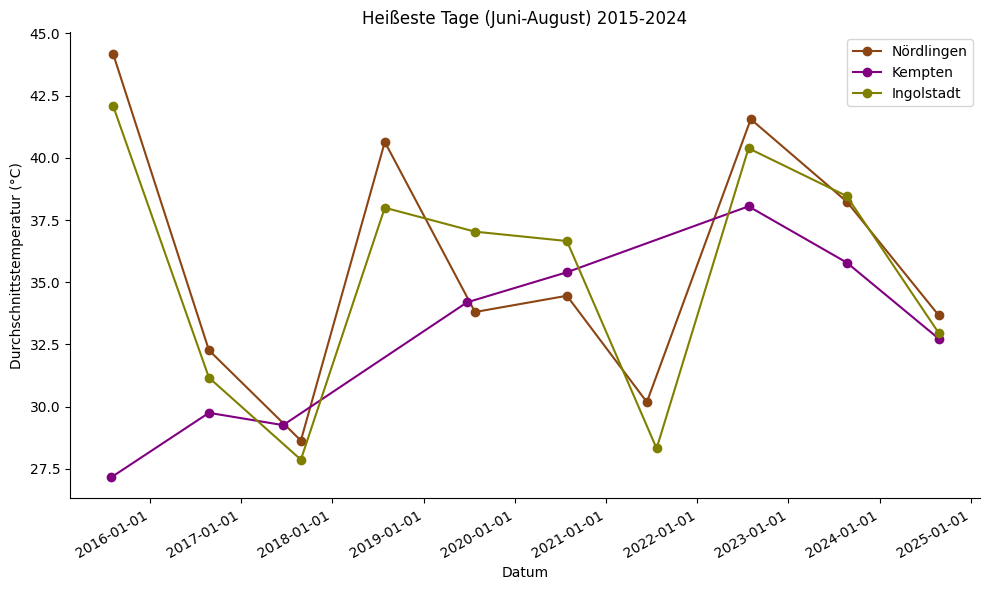

In [ ]:
city_colors = {
    "Nördlingen": "saddlebrown",
    "Kempten": "purple",
    "Ingolstadt": "olive",
}
# Diagramm erstellen
fig, ax = plt.subplots(figsize=(10, 6))

for city_name, hottest_days in all_hottest_days.items():
    dates = [datetime.strptime(day[0], '%Y-%m-%d') for day in hottest_days]  # Convert to datetime objects
    temps = [day[1] for day in hottest_days]

    # Access color from city_colors dictionary using city_name
    ax.plot(dates, temps, label=city_name, marker='o', color=city_colors[city_name])


ax.set_xlabel('Datum')
ax.set_ylabel('Durchschnittstemperatur (°C)')
ax.set_title('Heißeste Tage (Juni-August) 2015-2024')
ax.legend()

# Format the x-axis to display dates correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Use DateFormatter
fig.autofmt_xdate()  # Auto-format the dates for better readability

ax.spines['right'].set_visible(False)  # Rechten Rahmen ausblenden
ax.spines['top'].set_visible(False)    # Oberen Rahmen ausblenden

plt.tight_layout()  # Anpassung des Layouts, um Überlappungen zu vermeiden
plt.show()

# Maximalwerte (heißeste Tage) für Frühling, Herbst und Winter

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)

# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION PRO SZENE
def analyze_lst_per_scene(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden und in ee.Geometry umwandeln
    gdf = gpd.read_file(region_shapefile)

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER',50)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Check if the collection is empty before proceeding
    if landsat.size().getInfo() == 0:
        print(f"No images found for {region_name} between {start_date} and {end_date}. Skipping...")
        return []  # Return an empty list if no images are found


    # Liste für die Ergebnisse
    results = []

    # Iteration über jede Szene in der Sammlung
    for scene in landsat.toList(landsat.size()).getInfo():
        # Get the image ID from the scene dictionary
        scene_id = scene['id']

        # Create ee.Image object using the ID
        scene_image = ee.Image(scene_id)

        # Apply calculateLST to add the 'LST_Celsius' band *before* clipping
        scene_image = calculateLST(scene_image)

        # Now clip to the region
        scene_image = scene_image.clip(region)

        # Datum aus der Szene extrahieren
        scene_date = ee.Date(scene_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

        # Mittlere LST für die Szene (nur innerhalb der Stadt) berechnen
        mean_lst = scene_image.select('LST_Celsius').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,  # Geometrie der Stadt verwenden
            scale=30
        ).get('LST_Celsius').getInfo()

        # Ergebnisse zur Liste hinzufügen
        results.append([scene_date, mean_lst])

    # Den Tag mit der maximalen LST finden:
    max_lst_date = max(results, key=lambda x: x[1])[0]  # x[1] ist der LST-Wert
    max_lst_value = max(results, key=lambda x: x[1])[1]
    print(f"Der Tag mit der heißesten LST für {region_name} war {max_lst_date} mit einem Wert von {max_lst_value:.2f} °C.")

    return results

def find_hottest_day_average(results):
    """Findet den Tag mit der heißesten Durchschnittstemperatur in der Stadt."""

    # Return None if results is empty to avoid the ValueError
    if not results:
        return None, None

    daily_averages = {}
    for date, lst_value in results:
        if date in daily_averages:
            daily_averages[date].append(lst_value)
        else:
            daily_averages[date] = [lst_value]

    # Berechne die Durchschnittswerte für jeden Tag
    for date, lst_values in daily_averages.items():
        daily_averages[date] = sum(lst_values) / len(lst_values)

    # Finde den Tag mit der maximalen Durchschnittstemperatur
    hottest_day = max(daily_averages, key=daily_averages.get)
    hottest_day_lst = daily_averages[hottest_day]

    return hottest_day, hottest_day_lst


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'


# Zeiträume definieren
seasons = {
    "Frühling": ('2022-03-01', '2022-05-31'),
    "Herbst": ('2022-09-01', '2022-11-30'),
    "Winter": ('2022-12-01', '2023-02-28')  # Beachte: Winter geht über Jahreswechsel
}

# Restore the cities dictionary
cities = {
    'Nördlingen': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp',
    'Kempten': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp',
    'Ingolstadt': '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'
}

# Schleife über die Städte und Zeiträume
for city_name, shapefile_path in cities.items():
    for season_name, (start_date, end_date) in seasons.items():
        print(f"\nAnalyse für {city_name} im {season_name}:")
        results = analyze_lst_per_scene(shapefile_path, start_date, end_date, city_name)

        # Check if results is not empty before calling find_hottest_day_average
        if results:
            hottest_day, hottest_day_lst = find_hottest_day_average(results)  # Aufruf von find_hottest_day_average
            print(f"Der Tag mit der heißesten Durchschnittstemperatur für {city_name} im {season_name} war {hottest_day} mit einem Wert von {hottest_day_lst:.2f} °C.")
        else:
            print(f"No suitable images found for {city_name} in {season_name}. Skipping...") # Print a message if no images are found


Analyse für Nördlingen im Frühling:
Der Tag mit der heißesten LST für Nördlingen war 2022-05-22 mit einem Wert von 31.90 °C.
Der Tag mit der heißesten Durchschnittstemperatur für Nördlingen im Frühling war 2022-05-22 mit einem Wert von 31.90 °C.

Analyse für Nördlingen im Herbst:
Der Tag mit der heißesten LST für Nördlingen war 2022-09-04 mit einem Wert von 27.17 °C.
Der Tag mit der heißesten Durchschnittstemperatur für Nördlingen im Herbst war 2022-09-04 mit einem Wert von 27.17 °C.

Analyse für Nördlingen im Winter:
Der Tag mit der heißesten LST für Nördlingen war 2022-12-25 mit einem Wert von 6.21 °C.
Der Tag mit der heißesten Durchschnittstemperatur für Nördlingen im Winter war 2022-12-25 mit einem Wert von 6.21 °C.

Analyse für Kempten im Frühling:
Der Tag mit der heißesten LST für Kempten war 2022-05-15 mit einem Wert von 26.89 °C.
Der Tag mit der heißesten Durchschnittstemperatur für Kempten im Frühling war 2022-05-15 mit einem Wert von 26.89 °C.

Analyse für Kempten im Herbst:

# mittlere LST für Herbst 2015-2024

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 4) und Wolken (Bit 3) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION

def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.union_all()))

     # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 30)) \
        .map(maskClouds) \
        .map(calculateLST)
  # hier wird Cloud Cover Filterung entfernt oder angewendet

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)

    return mean_lst # mean_lst zurückgeben

# Define a function to calculate the mean autumn LST for a range of years
def calculate_mean_autumn_lst_for_years(region_shapefile, start_year, end_year, region_name):
    """Calculates the mean autumn LST for a range of years and returns an ee.Image."""

    # Create an empty list to store the autumn images for each year
    autumn_images = []

    # Loop through the years
    for year in range(start_year, end_year + 1):
        # Define the start and end dates for the current year's autumn
        start_date = f'{year}-09-01'
        end_date = f'{year}-11-30'

        # Calculate the mean LST image for the current year's autumn
        mean_lst_image = analyze_lst(region_shapefile, start_date, end_date, region_name)

        # Add the mean LST image to the list
        autumn_images.append(mean_lst_image)


    # Create an ee.ImageCollection from the list of autumn images
    autumn_collection = ee.ImageCollection(autumn_images)

    # Calculate the mean of all autumn images
    mean_autumn_lst_image = autumn_collection.mean()

    return mean_autumn_lst_image


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Städte und Shapefiles
cities = {
    'Nördlingen': noerdlingen_shapefile,
    'Kempten': kempten_shapefile,
    'Ingolstadt': ingolstadt_shapefile
}

# Create a dictionary to store the mean autumn LST images for each city
mean_autumn_lst_images = {}

# Loop through the cities and calculate the mean autumn LST image
for city_name, shapefile_path in cities.items():
    mean_autumn_lst_images[city_name] = calculate_mean_autumn_lst_for_years(shapefile_path, 2015, 2024, city_name)


# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()

lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in mean_autumn_lst_images.items():
    Map.addLayer(mean_lst_image, {'min': 10, 'max': 35, 'palette': lst_palette}, f'Mean LST {region_name} (Herbst 2015-2024)')

    # Load the shapefile for the region to display boundaries
    gdf = gpd.read_file(noerdlingen_shapefile if region_name == 'Nördlingen' else
                        kempten_shapefile if region_name == 'Kempten' else
                        ingolstadt_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': 10, 'max': 35, 'palette': lst_palette}, label="Land Surface Temperature Herbst 2015-2024 (°C)")
Map # Display the map


# Export as GeoTIFF
for city_name, mean_lst_image in mean_autumn_lst_images.items():
    # Define the filename
    filename = f'meanLST_30_{city_name}_alleherbst.tif'

    # Replace invalid characters in the filename for the description and fileNamePrefix
    valid_filename = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")

    # Load the shapefile for the region
    gdf = gpd.read_file(cities[city_name])  # Get the shapefile path from the cities dictionary

    # Reproject if necessary
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Create an ee.Geometry from the shapefile
    region = ee.Geometry(mapping(gdf.unary_union))

    # Export the image as GeoJSON
    task = ee.batch.Export.image.toDrive(
        image=mean_lst_image,
        description=valid_filename,  # Use valid_filename for description
        folder='LST_Exports', # Replace with your desired folder name
        fileNamePrefix=valid_filename.replace('.tif', ''),  # Use valid_filename for fileNamePrefix
        region=region.bounds(),
        scale=30,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Exporting {filename} to Google Drive...')

Exporting meanLST_30_Nördlingen_alleherbst.tif to Google Drive...
Exporting meanLST_30_Kempten_alleherbst.tif to Google Drive...
Exporting meanLST_30_Ingolstadt_alleherbst.tif to Google Drive...


# mittlere LST für Winter 2015/2024

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 4) und Wolken (Bit 3) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))
    # Maske auf das Bild anwenden
    return image.updateMask(mask)

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')         # Kelvin -> Celsius
    return image.addBands(lst_celsius)

# Funktion zur Analyse der LST für eine Region
def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    # Verwende union_all oder unary_union, je nachdem, was passt
    region = ee.Geometry(mapping(gdf.union_all()))

    # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 30)) \
        .map(maskClouds) \
        .map(calculateLST)

    # Check, ob Bilder vorhanden sind
    count = landsat.size().getInfo()
    if count == 0:
        print(f"Keine Bilder gefunden für {region_name} im Zeitraum {start_date} bis {end_date}.")
        return None

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)
    return mean_lst

# Funktion zur Berechnung der mean winter LST für einen Bereich von Jahren,
# wobei Jahre ohne Bilder übersprungen werden.
def calculate_mean_winter_lst_for_years(region_shapefile, start_year, end_year, region_name):
    """Berechnet die mittlere Winter-LST (Dezember bis Februar des Folgejahres) für die
    Jahre von start_year bis end_year-1 (z.B. 2014/2015 bis 2023/2024) und liefert ein ee.Image zurück."""
    winter_images = []

    # Loop: Für jedes Jahr im gewünschten Bereich
    for year in range(start_year, end_year):
        start_date = f'{year}-12-01'
        end_date = f'{year + 1}-02-28'
        print(f"Verarbeite Winterperiode: {start_date} bis {end_date} für {region_name}")

        mean_lst_image = analyze_lst(region_shapefile, start_date, end_date, region_name)
        if mean_lst_image is not None:
            winter_images.append(mean_lst_image)
        else:
            print(f"Überspringe Winterperiode {year}/{year+1}, da keine Bilder vorhanden.")

    if not winter_images:
        print(f"Für {region_name} wurden in keinem Winter gültige Bilder gefunden.")
        return None

    winter_collection = ee.ImageCollection(winter_images)
    mean_winter_lst_image = winter_collection.mean()
    return mean_winter_lst_image

# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Städte und Shapefiles
cities = {
    'Nördlingen': noerdlingen_shapefile,
    'Kempten': kempten_shapefile,
    'Ingolstadt': ingolstadt_shapefile
}

# Berechnung der mean winter LST für jede Stadt
mean_winter_lst_images = {}
for city_name, shapefile_path in cities.items():
    mean_img = calculate_mean_winter_lst_for_years(shapefile_path, 2014, 2024, city_name)
    if mean_img is not None:
        mean_winter_lst_images[city_name] = mean_img

# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()
lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in mean_winter_lst_images.items():
    Map.addLayer(mean_lst_image, {'min': -10, 'max': 25, 'palette': lst_palette}, f'Mean LST {region_name} (Winter 2015-2024)')

    # Shapefile laden zur Anzeige der Region
    gdf = gpd.read_file(cities[region_name])
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': -10, 'max': 25, 'palette': lst_palette}, label="Land Surface Temperature Winter (°C)")
Map

# Export as GeoTIFF
for city_name, mean_lst_image in mean_winter_lst_images.items():
    filename = f'meanLST_30_{city_name}_winter_2015-2024.tif'
    valid_filename = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")
    gdf = gpd.read_file(cities[city_name])
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region = ee.Geometry(mapping(gdf.unary_union))

    task = ee.batch.Export.image.toDrive(
        image=mean_lst_image,
        description=valid_filename,
        folder='LST_Exports',
        fileNamePrefix=valid_filename.replace('.tif', ''),
        region=region.bounds(),
        scale=30,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Exporting {filename} to Google Drive...')


Verarbeite Winterperiode: 2014-12-01 bis 2015-02-28 für Nördlingen
Keine Bilder gefunden für Nördlingen im Zeitraum 2014-12-01 bis 2015-02-28.
Überspringe Winterperiode 2014/2015, da keine Bilder vorhanden.
Verarbeite Winterperiode: 2015-12-01 bis 2016-02-28 für Nördlingen
Verarbeite Winterperiode: 2016-12-01 bis 2017-02-28 für Nördlingen
Keine Bilder gefunden für Nördlingen im Zeitraum 2016-12-01 bis 2017-02-28.
Überspringe Winterperiode 2016/2017, da keine Bilder vorhanden.
Verarbeite Winterperiode: 2017-12-01 bis 2018-02-28 für Nördlingen
Verarbeite Winterperiode: 2018-12-01 bis 2019-02-28 für Nördlingen
Verarbeite Winterperiode: 2019-12-01 bis 2020-02-28 für Nördlingen
Keine Bilder gefunden für Nördlingen im Zeitraum 2019-12-01 bis 2020-02-28.
Überspringe Winterperiode 2019/2020, da keine Bilder vorhanden.
Verarbeite Winterperiode: 2020-12-01 bis 2021-02-28 für Nördlingen
Verarbeite Winterperiode: 2021-12-01 bis 2022-02-28 für Nördlingen
Verarbeite Winterperiode: 2022-12-01 bis 202

code oben wurde aktualisiert mit print-überprüfungen, zeigt jetzt richtige Werte an

# mittlere LST für Frühling 2015-2024

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION

def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.unary_union))

     # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
        .map(maskClouds) \
        .map(calculateLST)
  # hier wird Cloud Cover Filterung entfernt oder angewendet

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)

    return mean_lst # mean_lst zurückgeben

# Define a function to calculate the mean spring LST for a range of years
def calculate_mean_spring_lst_for_years(region_shapefile, start_year, end_year, region_name):
    """Calculates the mean spring LST for a range of years and returns an ee.Image."""

    # Create an empty list to store the spring images for each year
    spring_images = []

    # Loop through the years
    for year in range(start_year, end_year + 1):
        # Define the start and end dates for the current year's spring
        start_date = f'{year}-03-01'
        end_date = f'{year}-05-31'

        # Calculate the mean LST image for the current year's spring
        mean_lst_image = analyze_lst(region_shapefile, start_date, end_date, region_name)

        # Add the mean LST image to the list
        spring_images.append(mean_lst_image)


    # Create an ee.ImageCollection from the list of spring images
    spring_collection = ee.ImageCollection(spring_images)

    # Calculate the mean of all spring images
    mean_spring_lst_image = spring_collection.mean()

    return mean_spring_lst_image


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Städte und Shapefiles
cities = {
    'Nördlingen': noerdlingen_shapefile,
    'Kempten': kempten_shapefile,
    'Ingolstadt': ingolstadt_shapefile
}

# Create a dictionary to store the mean spring LST images for each city
mean_spring_lst_images = {}

# Loop through the cities and calculate the mean winter LST image
for city_name, shapefile_path in cities.items():
    mean_spring_lst_images[city_name] = calculate_mean_spring_lst_for_years(shapefile_path, 2015, 2024, city_name)


# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()

lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in mean_spring_lst_images.items():
    Map.addLayer(mean_lst_image, {'min': 0, 'max': 30, 'palette': lst_palette}, f'Mean LST {region_name} (Herbst 2015-2024)')

    # Load the shapefile for the region to display boundaries
    gdf = gpd.read_file(noerdlingen_shapefile if region_name == 'Nördlingen' else
                        kempten_shapefile if region_name == 'Kempten' else
                        ingolstadt_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': 0, 'max': 30, 'palette': lst_palette}, label="Land Surface Temperature Frühling 2015-2024 (°C)")
Map # Display the map


# Export as GeoTIFF
for city_name, mean_lst_image in mean_spring_lst_images.items():
    # Define the filename
    filename = f'meanLST_10_{city_name}_spring_2015-2024.tif'

    # Replace invalid characters in the filename for the description and fileNamePrefix
    valid_filename = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")

    # Load the shapefile for the region
    gdf = gpd.read_file(cities[city_name])  # Get the shapefile path from the cities dictionary

    # Reproject if necessary
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Create an ee.Geometry from the shapefile
    region = ee.Geometry(mapping(gdf.unary_union))

    # Export the image as GeoJSON
    task = ee.batch.Export.image.toDrive(
        image=mean_lst_image,
        description=valid_filename,  # Use valid_filename for description
        folder='LST_Exports', # Replace with your desired folder name
        fileNamePrefix=valid_filename.replace('.tif', ''),  # Use valid_filename for fileNamePrefix
        region=region.bounds(),
        scale=30,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Exporting {filename} to Google Drive...')

Exporting meanLST_10_Nördlingen_spring_2015-2024.tif to Google Drive...
Exporting meanLST_10_Kempten_spring_2015-2024.tif to Google Drive...
Exporting meanLST_10_Ingolstadt_spring_2015-2024.tif to Google Drive...


# mittlere LST für Sommer 2015-2024

In [ ]:
# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)

# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


# FUNKTION ZUR ANALYSE DER LST FÜR EINE REGION

def analyze_lst(region_shapefile, start_date, end_date, region_name):
    # Region aus Shapefile laden
    gdf = gpd.read_file(region_shapefile)
    region = ee.Geometry(mapping(gdf.unary_union))

     # CRS sicherstellen (WGS84)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # In WGS84 projizieren

    region = ee.Geometry(mapping(gdf.unary_union))

    # Landsat 8-Daten abrufen und verarbeiten
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
        .map(maskClouds) \
        .map(calculateLST)
  # hier wird Cloud Cover Filterung entfernt oder angewendet

    # Mittlere LST berechnen und auf die Region zuschneiden
    mean_lst = landsat.select('LST_Celsius').mean().clip(region)

    return mean_lst # mean_lst zurückgeben

# Define a function to calculate the mean summer LST for a range of years
def calculate_mean_summer_lst_for_years(region_shapefile, start_year, end_year, region_name):
    """Calculates the mean summer LST for a range of years and returns an ee.Image."""

    # Create an empty list to store the summer images for each year
    summer_images = []

    # Loop through the years
    for year in range(start_year, end_year + 1):
        # Define the start and end dates for the current year's summer
        start_date = f'{year}-06-01'
        end_date = f'{year}-08-31'

        # Calculate the mean LST image for the current year's summer
        mean_lst_image = analyze_lst(region_shapefile, start_date, end_date, region_name)

        # Add the mean LST image to the list
        summer_images.append(mean_lst_image)


    # Create an ee.ImageCollection from the list of spring images
    summer_collection = ee.ImageCollection(summer_images)

    # Calculate the mean of all spring images
    mean_summer_lst_image = summer_collection.mean()

    return mean_summer_lst_image


# Shapefile-Pfade
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Städte und Shapefiles
cities = {
    'Nördlingen': noerdlingen_shapefile,
    'Kempten': kempten_shapefile,
    'Ingolstadt': ingolstadt_shapefile
}

# Create a dictionary to store the mean summer LST images for each city
mean_summer_lst_images = {}

# Loop through the cities and calculate the mean summer LST image
for city_name, shapefile_path in cities.items():
    mean_summer_lst_images[city_name] = calculate_mean_summer_lst_for_years(shapefile_path, 2015, 2024, city_name)


# Karte erstellen und Ergebnisse hinzufügen
Map = geemap.Map()

lst_palette = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']

for region_name, mean_lst_image in mean_summer_lst_images.items():
    Map.addLayer(mean_lst_image, {'min':10, 'max': 40, 'palette': lst_palette}, f'Mean LST {region_name} (Herbst 2015-2024)')

    # Load the shapefile for the region to display boundaries
    gdf = gpd.read_file(noerdlingen_shapefile if region_name == 'Nördlingen' else
                        kempten_shapefile if region_name == 'Kempten' else
                        ingolstadt_shapefile)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    region_boundary = ee.Geometry(mapping(gdf.unary_union))
    Map.addLayer(region_boundary, {}, f'{region_name} Boundary')

Map.add_colorbar(vis_params={'min': 10, 'max': 40, 'palette': lst_palette}, label="Land Surface Temperature Frühling 2015-2024 (°C)")
Map # Display the map


# Export as GeoTIFF
for city_name, mean_lst_image in mean_summer_lst_images.items():
    # Define the filename
    filename = f'meanLST_10_{city_name}_summer_2015_2024.tif'

    # Replace invalid characters in the filename for the description and fileNamePrefix
    valid_filename = filename.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue")

    # Load the shapefile for the region
    gdf = gpd.read_file(cities[city_name])  # Get the shapefile path from the cities dictionary

    # Reproject if necessary
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Create an ee.Geometry from the shapefile
    region = ee.Geometry(mapping(gdf.unary_union))

    # Export the image as GeoJSON
    task = ee.batch.Export.image.toDrive(
        image=mean_lst_image,
        description=valid_filename,  # Use valid_filename for description
        folder='LST_Exports', # Replace with your desired folder name
        fileNamePrefix=valid_filename.replace('.tif', ''),  # Use valid_filename for fileNamePrefix
        region=region.bounds(),
        scale=30,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f'Exporting {filename} to Google Drive...')

Exporting meanLST_10_Nördlingen_summer_2015_2024.tif to Google Drive...
Exporting meanLST_10_Kempten_summer_2015_2024.tif to Google Drive...
Exporting meanLST_10_Ingolstadt_summer_2015_2024.tif to Google Drive...


für ingolstadt immer der westliche Teil besser aufgelöst, weil mehr Daten vorhanden

min und max der saisons prüfen, um histogramme in qgis zu validieren

In [ ]:
# Zunächst: Funktion zur Reduktion (min und max) eines Bildes
def compute_min_max(image, region_geom):
    # Kombiniere die Reducer für min und max in einem Schritt.
    reducers = ee.Reducer.min().combine(ee.Reducer.max(), sharedInputs=True)
    stats = image.reduceRegion(
        reducer=reducers,
        geometry=region_geom,
        scale=30,
        maxPixels=1e9
    )
    return stats

# Funktion zur Ausgabe der Statistiken für eine Saison
def print_seasonal_stats(season_name, seasonal_images, cities_dict):
    print(f"--- Statistiken für {season_name} ---")
    for city, seasonal_image in seasonal_images.items():
        # Shapefile laden
        gdf = gpd.read_file(cities_dict[city])
        # CRS in WGS84, falls nötig
        if gdf.crs != "EPSG:4326":
            gdf = gdf.to_crs("EPSG:4326")
        # Erstelle die Region als ee.Geometry
        region_geom = ee.Geometry(mapping(gdf.unary_union))

        # Berechne min und max Werte
        stats = compute_min_max(seasonal_image, region_geom)
        stats_dict = stats.getInfo()
        min_val = stats_dict.get('LST_Celsius_min')
        max_val = stats_dict.get('LST_Celsius_max')
        print(f"{city}: min = {min_val}, max = {max_val}")

# Beispiel: Wir gehen davon aus, dass du bereits zwei Dictionaries hast:
#  - mean_autumn_lst_images (für Herbst: z. B. Zeitraum 01.09 bis 30.11)
#  - mean_winter_lst_images (für Winter: Zeitraum 01.12 bis 28.02 des Folgejahres)
#
# Damit erhalten wir beispielsweise folgende Ausgabe:

print_seasonal_stats("Herbst (2015-2024)", mean_autumn_lst_images, cities)
print_seasonal_stats("Winter (2015/2016 - 2023/2024)", mean_winter_lst_images, cities)


--- Statistiken für Herbst (2015-2024) ---
Nördlingen: min = 15.389598368750027, max = 32.42963861750003
Kempten: min = -3.5178201399999693, max = 25.74840644000002
Ingolstadt: min = 16.719136940000013, max = 42.95317287285716
--- Statistiken für Winter (2015/2016 - 2023/2024) ---
Nördlingen: min = None, max = None
Kempten: min = -12.16199272, max = 7.033607599999982
Ingolstadt: min = None, max = None


# mittlere LST-Werte über gesamtem Stadtgebiet für alle Sommer extrahieren

In [ ]:
# Shapefile paths
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Funktion zur Maskierung von Wolken und Schatten
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 4)  # 00001000 = 16
    cloud_bitmask = (1 << 3)         # 00100000 = 8

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


# Function to calculate LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')
    return image.addBands(lst_celsius)

# --- Main part of the script ---

# Define a dictionary to store mean LST values for each city and year
city_yearly_means = {}

# Loop through the years
for year in range(2015, 2025):  # Years 2015 to 2024
    start_date = f'{year}-06-01'
    end_date = f'{year}-08-31'

    # Loop through the cities
    for city_name, shapefile_path in [('Nördlingen', noerdlingen_shapefile), ('Kempten', kempten_shapefile), ('Ingolstadt', ingolstadt_shapefile)]:
        # Load the shapefile
        gdf = gpd.read_file(shapefile_path)
        if gdf.crs != "EPSG:4326":
            gdf = gdf.to_crs("EPSG:4326")
        region = ee.Geometry(mapping(gdf.union_all()))

        # Get and process Landsat data
        landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
            .map(maskClouds) \
            .map(calculateLST)

        # Check if the collection is empty before calculating the mean
        if landsat.size().getInfo() > 0:  # Check if collection has images
            # Calculate mean LST for the city and year
            mean_lst = landsat.select('LST_Celsius').mean().reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=30  # Adjust scale if necessary
            ).get('LST_Celsius').getInfo()

            # Store the mean LST in the dictionary
            if city_name not in city_yearly_means:
                city_yearly_means[city_name] = {}
            city_yearly_means[city_name][year] = mean_lst
        else:
            print(f"Warning: No images found for {city_name} in {year} with cloud cover < 10%.")
            # You can choose to skip this year or assign a default value here.


# Print the results
for city_name, yearly_means in city_yearly_means.items():
    print(f"Stadt: {city_name}")
    for year, mean_lst in yearly_means.items():
        print(f"  Jahr {year}: {mean_lst:.2f} °C")
    print("-" * 20)

Stadt: Nördlingen
  Jahr 2015: 38.93 °C
  Jahr 2016: 30.83 °C
  Jahr 2017: 28.64 °C
  Jahr 2018: 40.63 °C
  Jahr 2019: 31.77 °C
  Jahr 2020: 32.28 °C
  Jahr 2021: 29.83 °C
  Jahr 2022: 36.30 °C
  Jahr 2023: 38.24 °C
  Jahr 2024: 33.68 °C
--------------------
Stadt: Kempten
  Jahr 2015: 27.16 °C
  Jahr 2016: 29.75 °C
  Jahr 2017: 29.26 °C
  Jahr 2019: 32.37 °C
  Jahr 2020: 31.87 °C
  Jahr 2022: 32.44 °C
  Jahr 2023: 35.79 °C
  Jahr 2024: 31.98 °C
--------------------
Stadt: Ingolstadt
  Jahr 2015: 36.93 °C
  Jahr 2016: 29.01 °C
  Jahr 2017: 27.87 °C
  Jahr 2018: 38.00 °C
  Jahr 2019: 32.26 °C
  Jahr 2020: 33.00 °C
  Jahr 2021: 28.46 °C
  Jahr 2022: 34.73 °C
  Jahr 2023: 38.46 °C
  Jahr 2024: 32.97 °C
--------------------


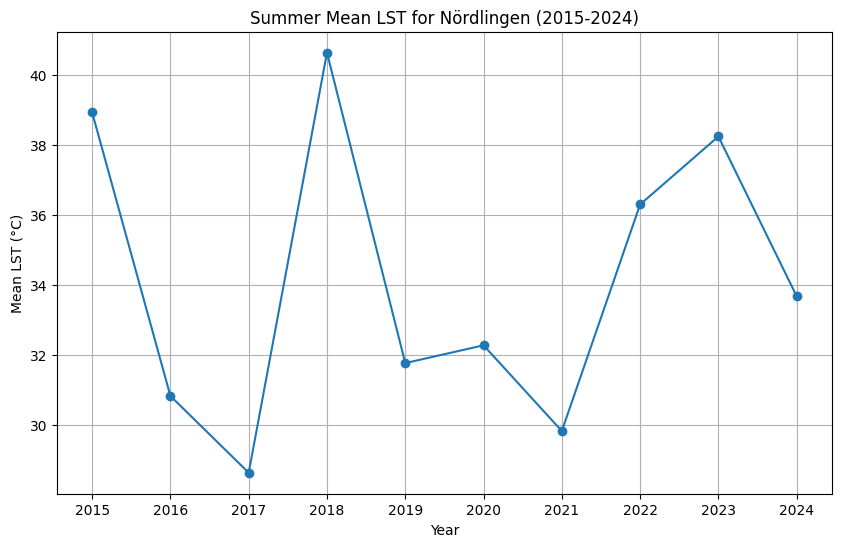

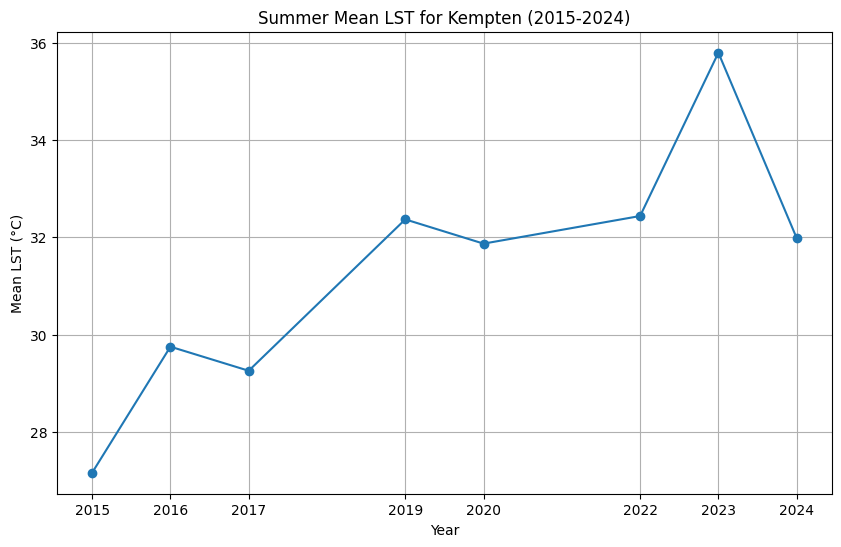

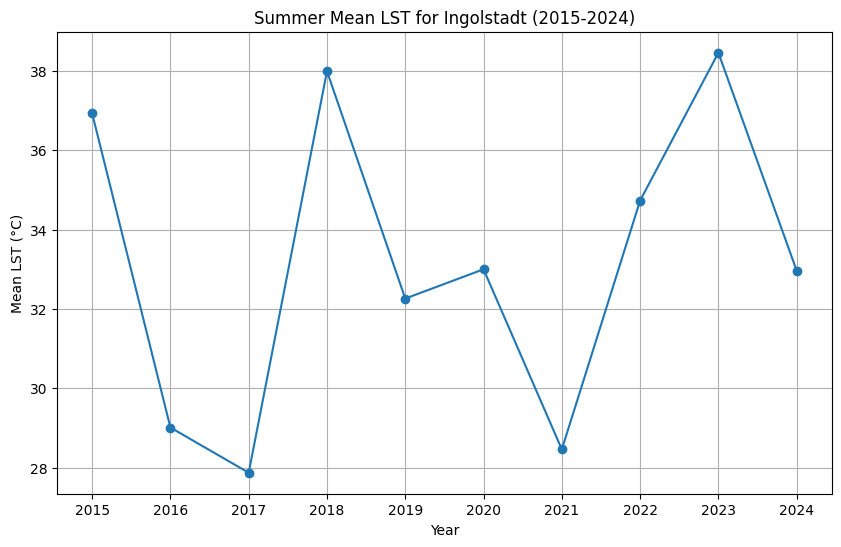

In [ ]:
# Assuming city_yearly_means is your dictionary from the previous code

# Create separate charts for each city
for city_name, yearly_means in city_yearly_means.items():
    years = list(yearly_means.keys())
    lst_values = list(yearly_means.values())

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(years, lst_values, marker='o', linestyle='-')  # Plot with markers and lines
    plt.title(f'Summer Mean LST for {city_name} (2015-2024)')
    plt.xlabel('Year')
    plt.ylabel('Mean LST (°C)')
    plt.grid(True)
    plt.xticks(years)  # Set x-axis ticks to show all years
    plt.show()

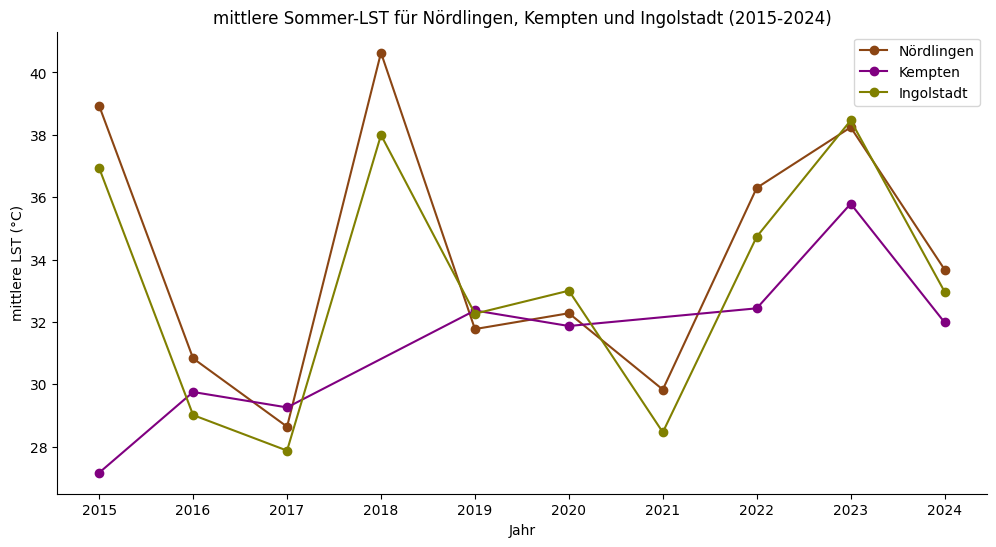

In [ ]:
# Assuming city_yearly_means is your dictionary from the previous code
city_colors = {
    "Nördlingen": "saddlebrown",
    "Kempten": "purple",
    "Ingolstadt": "olive",
}

fig = plt.figure(figsize=(12, 6))  # Adjust figure size as needed
ax = fig.add_subplot(111)  # Add a subplot to the figure

for city_name, yearly_means in city_yearly_means.items():
    years = list(yearly_means.keys())
    lst_values = list(yearly_means.values())

    ax.plot(years, lst_values, marker='o', linestyle='-', label=city_name, color=city_colors[city_name])  # Add label for legend


ax.set_title('mittlere Sommer-LST für Nördlingen, Kempten und Ingolstadt (2015-2024)')
ax.set_xlabel('Jahr')
ax.set_ylabel('mittlere LST (°C)')
ax.grid(False)
ax.set_xticks(years)  # Set x-axis ticks to show all years
ax.legend()  # Add legend to differentiate cities

ax.spines['right'].set_visible(False)  # Rechten Rahmen ausblenden
ax.spines['top'].set_visible(False)    # Oberen Rahmen ausblenden

plt.show()